> For the given dataset lets findout the shapes of nodules

In [103]:
import torch
import cv2
import numpy as np
import pandas as pd
import fastcore.all as fc 

from safetensors.numpy import load_file
from tqdm import tqdm
from voxdet.tfsm.voxt import RandPosCrop

In [104]:
import matplotlib.pyplot as plt
plt.style.use("bmh")
%matplotlib inline

In [105]:
sids = fc.L(pd.concat([pd.read_csv(i) for i in fc.Path("../studies/only_lidc/folds1/").glob("folds_*.csv")], axis=0)["scans"].unique().tolist())
sids

(#883) ['1.3.6.1.4.1.14519.5.2.1.6279.6001.534006575256943390479252771547','1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421','1.3.6.1.4.1.14519.5.2.1.6279.6001.162901839201654862079549658100','1.3.6.1.4.1.14519.5.2.1.6279.6001.483655032093002252444764787700','1.3.6.1.4.1.14519.5.2.1.6279.6001.144883090372691745980459537053','1.3.6.1.4.1.14519.5.2.1.6279.6001.655242448149322898770987310561','1.3.6.1.4.1.14519.5.2.1.6279.6001.335866409407244673864352309754','1.3.6.1.4.1.14519.5.2.1.6279.6001.302876782304722412779805665588','1.3.6.1.4.1.14519.5.2.1.6279.6001.259123825760999546551970425757','1.3.6.1.4.1.14519.5.2.1.6279.6001.561458563853929400124470098603'...]

In [106]:
sid = f"/qct_cache/lidc_cache_qct/{sids[np.random.randint(len(sids))]}.safetensors"
fc.Path(sid).exists()

True

In [107]:
img = load_file(sid)
img["images"].shape, img["boxes"] #boxes are of the zyxzyx and images are of shape zyx

((280, 210, 290),
 array([[219.5       , 136.61035156, 106.77636719, 222.5       ,
         139.80371094, 109.33105469],
        [203.5       , 140.44238281, 254.94824219, 207.5       ,
         145.55175781, 260.69628906],
        [192.5       ,  63.80175781,  62.70800781, 198.5       ,
          68.27246094,  65.90136719],
        [183.5       ,  72.10449219,  25.02636719, 186.5       ,
          75.93652344,  28.85839844],
        [174.5       , 115.53417969, 241.53613281, 179.5       ,
         119.36621094, 245.36816406],
        [168.5       , 100.84472656,  19.27832031, 171.5       ,
         107.23144531,  24.38769531],
        [148.5       , 173.65332031, 119.54980469, 152.5       ,
         178.12402344, 122.10449219],
        [147.5       ,  49.11230469,  87.61621094, 150.5       ,
          51.66699219,  90.80957031],
        [142.5       ,  26.75878906, 221.73730469, 147.5       ,
          30.59082031, 227.48535156],
        [124.5       , 192.81347656, 200.02246094, 130.

In [108]:
sid = f"/qct_cache/lidc_cache_qct/{sids[np.random.randint(len(sids))]}.safetensors"
img = load_file(sid)
rpc = RandPosCrop(crop_size=(96, 192, 192))
nimg = rpc(img)
boxes =nimg["boxes"]
boxes = torch.Tensor(boxes)
boxes.shape, nimg["images"].shape

(torch.Size([1, 6]), (96, 192, 192))

In [109]:
boxes.shape

torch.Size([1, 6])

In [110]:
abox = torch.empty((0, 6))

In [111]:
abox = torch.cat([abox, boxes])
abox

tensor([[41.7605, 76.4219, 49.6094, 48.0210, 88.1406, 58.2031]])

In [112]:
abox = torch.empty((0, 6))
for sid in tqdm(sids):
    loc = f"/qct_cache/lidc_cache_qct/{sid}.safetensors"
    if not fc.Path(loc).exists(): continue
    img = load_file(f"/qct_cache/lidc_cache_qct/{sid}.safetensors")
    for _ in range(5):
        nimg = rpc(img)
        boxes =nimg["boxes"]
        boxes = torch.Tensor(boxes)
        abox = torch.cat([abox, boxes])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 883/883 [11:04<00:00,  1.33it/s]


In [113]:
print(abox.shape)
abox

torch.Size([7960, 6])


tensor([[ 81.6771,  75.3965, 184.0020,  87.2587,  82.6230, 189.0605],
        [ 64.9321, 110.0840, 180.3887,  70.5138, 119.4785, 190.5059],
        [ 26.6771,  59.3965, 183.0020,  32.2587,  66.6230, 188.0605],
        ...,
        [ 28.6186,  10.2734,  15.1172,  34.8241,  22.9297,  28.4766],
        [ 23.0336,  27.1484,  10.1953,  27.9980,  39.1016,  18.6328],
        [ 13.7253,  48.2422,  15.1172,  18.6897,  57.3828,  24.2578]])

> store this tensor object as `.pt` file. 

- abox : 96, 192, 192
- abox_192: 192, 192, 192

In [116]:
torch.save(abox, "abox.pt")

In [117]:
abox = torch.load("abox.pt")
abox.shape

torch.Size([7960, 6])

(x1, y1) --- (x2, y1)

(x1, y2) ---- (x2, y2)

In [118]:
def draw_bbox(image, x1, y1, x2, y2):
    # Define 3D bounding box vertices
    front_top_left = (x1, y1)
    front_top_right = (x2, y1)
    front_bottom_left = (x1, y2)
    front_bottom_right = (x2, y2)

    # Draw front face
    cv2.rectangle(image, front_top_left, front_bottom_right, (0, 255, 0), 1)

In [119]:
# Example usage
imgxy = np.ones((192, 192, 3), dtype=np.uint8) * 255  # White background
imgxz = np.ones((192, 192, 3), dtype=np.uint8) * 255  # White background


# Define 3D bounding box coordinates
x1, y1, z1 = 50, 50, 20
x2, y2, z2 = 150, 150, 40

# Draw 3D bounding box on the image
draw_bbox(imgxy, x1, y1, x2, y2)
draw_bbox(imgxz, z1, y1, z2, y2)

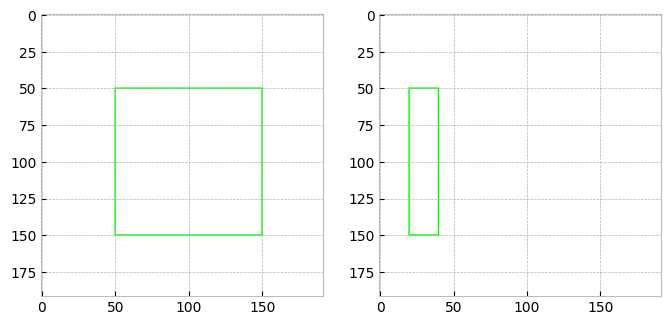

In [120]:
fig, ax = plt.subplots(figsize=(8, 4), nrows=1, ncols=2)
ax.flat[0].imshow(imgxy)
ax.flat[1].imshow(imgxz)

In [121]:
## lets do this for all bboxes:
imgxy = np.ones((192, 192, 3), dtype=np.uint8) * 255  # White background
imgxz = np.ones((192, 192, 3), dtype=np.uint8) * 255  # White background
imgyz = np.ones((192, 192, 3), dtype=np.uint8) * 255  # White background

for t in abox:
    z1, y1, x1, z2, y2, x2 = t.tolist()
    xc, yc = x1+((x2-x1)/2), y1+((y2-y1)/2)
    h = (y2-y1)
    w = (x2-x1)
    d = (z2-z1)
    x1, y1 = int(96-(w/2)), int(96-(h/2))
    x2, y2 = int(96+(w/2)), int(96+(h/2))
    z1, z2 = int(48-(d/2)), int(48+(h/2))
    
    draw_bbox(imgxy, x1, y1, x2, y2)
    draw_bbox(imgyz, z1, y1, z2, y2)
    draw_bbox(imgxz, z1, x1, z2, x2)

Text(0.5, 1.0, 'yz - side view')

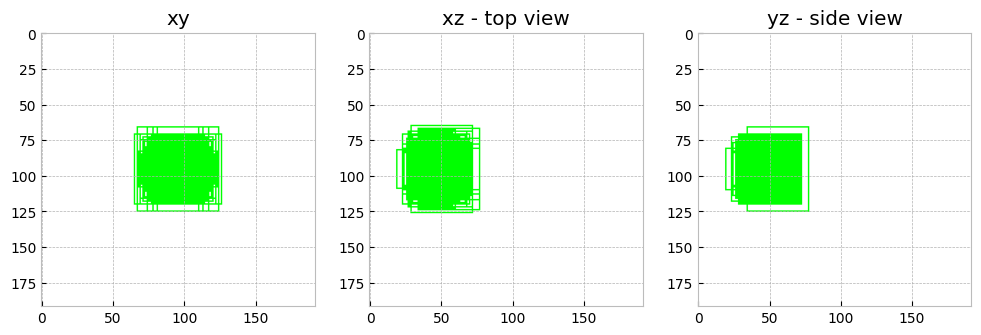

In [122]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=3)
ax.flat[0].imshow(imgxy)
ax.flat[0].set_title("xy")
ax.flat[1].imshow(imgxz)
ax.flat[1].set_title("xz - top view")
ax.flat[2].imshow(imgyz)
ax.flat[2].set_title("yz - side view")

## scatter plots 

In [123]:
z = abox[:, 3] - abox[:, 0]
y = abox[:, 4] - abox[:, 1]
x = abox[:, 5] - abox[:, 2]
zyx = torch.vstack([z, y, x]).T.numpy()


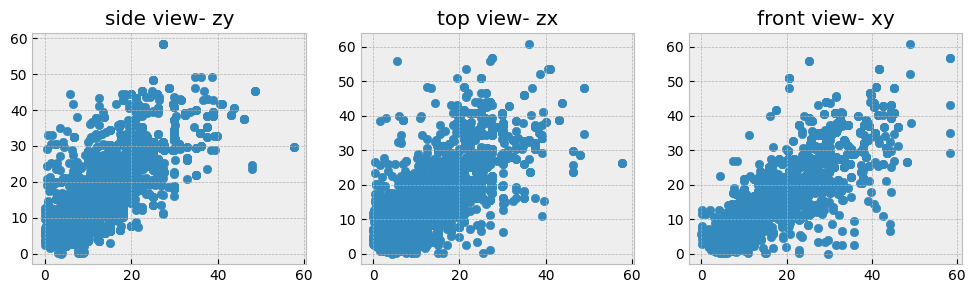

In [124]:
fig, ax = plt.subplots(figsize=(12, 3), nrows=1, ncols=3)
ax.flat[0].scatter(zyx[:, 0], zyx[:, 1])
ax.flat[0].set_title("side view- zy")
ax.flat[1].scatter(zyx[:, 0], zyx[:, 2])
ax.flat[1].set_title("top view- zx")
ax.flat[2].scatter(zyx[:, 1], zyx[:, 2])
ax.flat[2].set_title("front view- xy")
plt.show()

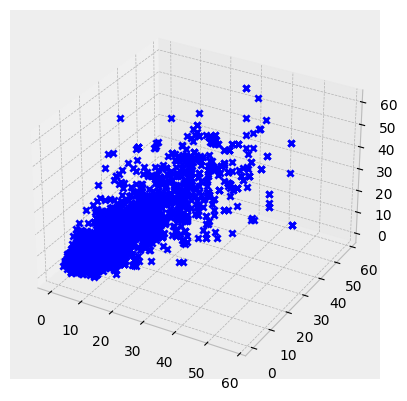

In [125]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for point in zyx:
    z, y, x = point
    ax.scatter(z, y, x, c='b', marker='x')

plt.show()

In [126]:
hw = zyx[:, 1]/zyx[:, 2]
hd = zyx[:, 1]/zyx[:, 0]
wd = zyx[:, 2]/zyx[:, 0]

ar = np.vstack([hd, hw, wd]).T

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# for point in ar:
#     z, y, x = point
#     ax.scatter(z, y, x, c='b', marker='x')

# plt.show()

In [127]:
np.median(ar, axis=0), np.mean(ar, axis=0), np.max(ar, axis=0), np.min(ar, axis=0)

(array([1.1525458, 1.       , 1.1425781], dtype=float32),
 array([1.7291766, 1.3058401, 1.6649292], dtype=float32),
 array([ 564.7059 , 1011.3333 ,  470.58823], dtype=float32),
 array([0.00208333, 0.00138889, 0.0033701 ], dtype=float32))

origial: array([6.153127 , 3.1666667, 6.1875 ], dtype=float32), array([0.28079343, 0.4057971 , 0.20742187], dtype=float32))

In [128]:
ar[(ar > np.asarray([6.153127 , 3.1666667, 6.1875 ])).sum(axis=1) >=1].shape[0] # around 220/10k 2.2%

193

In [129]:
ar[(ar <= np.asarray([0.28079343, 0.4057971 , 0.20742187])).sum(axis=1) >=1].shape[0] # around 220/10k  1.46%

75

In [142]:
tt = ar[((ar <= np.asarray([0.28079343, 0.4057971 , 0.20742187])) | (ar > np.asarray([6.153127 , 3.1666667, 6.1875 ]))).sum(axis=1)>=1]
tt.shape

(228, 3)

In [131]:
22800/abox.shape[0]

2.864321608040201

## Volume game 

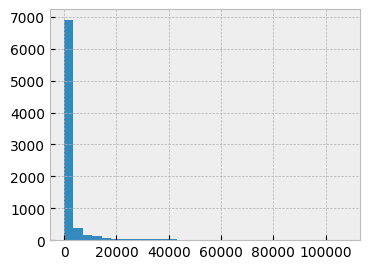

In [132]:
vol = zyx.prod(axis=1)
plt.figure(figsize=(4, 3))
plt.hist(vol, bins=30)
plt.show()

In [133]:
vol.min(), vol.max(), vol.mean(), np.median(vol)

(0.06412156, 107694.35, 2623.7478, 303.97223)

In [136]:
vol[vol<27].shape, zyx[(zyx>30).sum(axis=1).nonzero()[0]].shape

((184,), (444, 3))

## aspect ratio in all direction

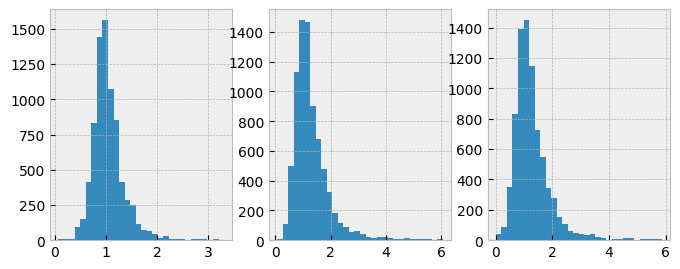

In [19]:
fig, ax = plt.subplots(figsize=(8, 3), nrows=1, ncols=3)
hw = (h.numpy()/w.numpy())
hw = hw[hw<np.percentile(hw, 99)]

hd = (h.numpy()/d.numpy())
hd = hd[hd<np.percentile(hd, 99)]

wd = (w.numpy()/d.numpy())
wd = wd[wd<np.percentile(wd, 99)]


ax.flat[0].hist(hw, bins=30)
ax.flat[1].hist(hd, bins=30)
ax.flat[2].hist(wd, bins=30)
plt.show()

In [24]:
ar = np.vstack([hd, hw, wd])
np.median(ar, axis=1), np.mean(ar, axis=1), \
np.max(ar, axis=1), np.min(ar, axis=1)

(array([1.1386622, 1.       , 1.1338459], dtype=float32),
 array([1.3055059, 1.0536377, 1.2794075], dtype=float32),
 array([6.0546875, 3.3084111, 5.8628473], dtype=float32),
 array([0.0703125 , 0.07166667, 0.00044714], dtype=float32))

> since aspect ratios are the same in all directions, we have to keep all directions the same. i.e instead of (2,4,4) we need to anchor box as (4, 4, 4)

In [29]:
torch.stack([h, w, d], axis=1)[:20, :]

tensor([[ 8.6719,  5.7812,  3.7211],
        [17.3438, 20.2344, 11.7835],
        [26.7383, 12.4902,  4.2752],
        [17.3438, 20.2344, 11.7835],
        [26.7383, 27.4609, 16.1248],
        [ 7.2266,  5.0586,  5.5816],
        [ 9.3945, 10.1172,  5.5816],
        [ 7.2266,  4.9980,  5.5816],
        [ 9.3945,  8.6113,  5.5816],
        [26.7383, 27.4609, 16.1248],
        [13.0078, 14.4531,  7.7706],
        [ 6.4453,  3.8672,  4.3418],
        [ 8.3789,  8.3789,  3.1013],
        [ 8.3789,  8.3789,  3.1013],
        [ 9.0234,  9.0234,  6.8228],
        [ 6.4453,  3.8672,  4.3418],
        [ 8.3789,  8.3789,  3.1013],
        [ 9.0234,  9.0234,  6.8228],
        [ 8.3789,  8.3789,  3.1013],
        [ 3.6328,  4.2383,  5.3938]])

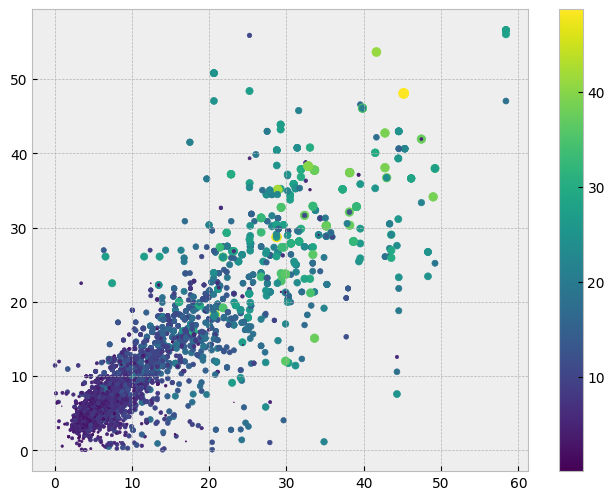

In [184]:
#fig, ax = plt.subplots(figsize=(8, 3), nrows=1, ncols=1)
plt.figure(figsize=(8, 6))
sc = plt.scatter(w.numpy(), h.numpy(), s=d.numpy(), c=d.numpy())
plt.xlabel("w")
plt.ylabel("h")
plt.colorbar(sc)
plt.show()

>TODO: we will create two different anchor boxes stride and check which one has 
    - mean & std iou for top 12 
    - how many are positive 
    - +bbox iou

> square boxes might work better( [4, 4, 4] than [2, 4, 4]) as most of the nodules are of that shape?

> want to see reg error with aspect ratio, area of the bbox.